In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import ndimage, stats
import math
from h5py import File
from collections import defaultdict
import pybedtools as pbt
from collections import OrderedDict
import seaborn.apionly as sns
from ipyparallel import Client
_RC = Client()
_DVIEW = _RC[:]

In [2]:
def bed_to_score_array(bed_file):
    chrom = bed_file.split('/')[-1].split('.')[0]
    chromInfo = {
        'chr1': 249250621, 'chr2': 243199373, 'chr3': 198022430, 'chr4': 191154276,
        'chr5': 180915260, 'chr6': 171115067, 'chr7': 159138663, 'chrX': 155270560,
        'chr8': 146364022, 'chr9': 141213431, 'chr10': 135534747, 'chr11': 135006516,
        'chr12': 133851895, 'chr13': 115169878, 'chr14': 107349540, 'chr15': 102531392,
        'chr16': 90354753, 'chr17': 81195210, 'chr18': 78077248, 'chr20': 63025520,
        'chrY': 59373566, 'chr19': 59128983, 'chr22': 51304566, 'chr21': 48129895
    }
    a = np.zeros(chromInfo[chrom])
    with open(bed_file) as handle:
        for line in handle:
            c = line.rstrip('\n').split('\t')
            a[int(c[1]): int(c[2])+1] = float(c[4])
    return a

def bin_array(a, bs):
    t = a.shape[0] % bs
    rows = a.shape[0] // bs
    ba = np.sum(a[:-t].reshape(rows, bs), axis=1)
    return np.append(ba, a[-t:].sum())

def load_h5_data(fn, f):
    return np.array(File(fn).get('shape/%s' % f))

In [3]:
qg_dir = './data/QuadGraphs_bed'
phatcons_dir = './data/phastcons/chrom_arrays'
dbsnp_dir = './data/dbsnp/chrom_arrays/'
shape_dir = './data/dna_shape/hdf5_files'
chrom_arrays = {}
chroms = ['chr'+str(x) for x in range(1, 23)] + ['chrX', 'chrY']
for chrom in chroms:
    print ('\r%s' % chrom, end='')
    chrom_arrays[chrom] = {}
    chrom_arrays[chrom]['qg'] = bed_to_score_array('%s/%s.bed' % (qg_dir, chrom))
    chrom_arrays[chrom]['pc'] = np.load("%s/%s.npy" % (phatcons_dir, chrom))
    chrom_arrays[chrom]['snp'] = np.load("%s/%s.npy" % (dbsnp_dir, chrom))
#     chrom_arrays[chrom]['HelT'] = load_h5_data("%s/%s_HelT.h5" % (shape_dir, chrom), 'HelT')
#     chrom_arrays[chrom]['MGW'] = load_h5_data("%s/%s_MGW.h5" % (shape_dir, chrom), 'MGW')
#     chrom_arrays[chrom]['ProT'] = load_h5_data("%s/%s_ProT.lh5" % (shape_dir, chrom), 'ProT')
#     chrom_arrays[chrom]['Roll'] = load_h5_data("%s/%s_Roll.h5" % (shape_dir, chrom), 'Roll')

chrY

In [4]:
binned_chroms = {}
for chrom in chroms:
    print ("\r%s" % chrom, end='')
    binned_chroms[chrom] = {}
    binned_chroms[chrom]['qg'] = bin_array(chrom_arrays[chrom]['qg'], bs=10000)
    binned_chroms[chrom]['pc'] = bin_array(chrom_arrays[chrom]['pc'], bs=10000)
    binned_chroms[chrom]['snp'] = bin_array(chrom_arrays[chrom]['snp'], bs=10000)
#     binned_chroms[chrom]['MGW'] = bin_array(chrom_arrays[chrom]['MGW'], bs=10000)
#     binned_chroms[chrom]['HelT'] = bin_array(chrom_arrays[chrom]['HelT'], bs=10000)
#     binned_chroms[chrom]['ProT'] = bin_array(chrom_arrays[chrom]['ProT'], bs=10000)
#     binned_chroms[chrom]['Roll'] = bin_array(chrom_arrays[chrom]['Roll'], bs=10000)

chrY

In [5]:
factor = 5
smoothened = defaultdict(list)
points = []
for chrom in chroms:
    for key in binned_chroms[chrom]:
        s = binned_chroms[chrom][key].copy()
        s = s / s.max()
        s = ndimage.gaussian_filter1d(s, factor)
        smoothened[key].extend(s)
    points.append(len(binned_chroms[chrom][key]))
smoothened = dict(smoothened)
for key in smoothened:
    smoothened[key] = np.array(smoothened[key])

snp


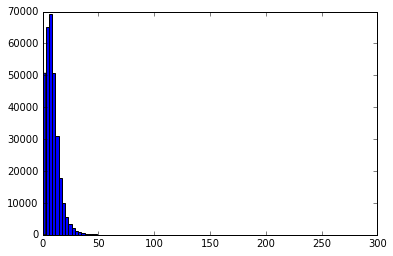

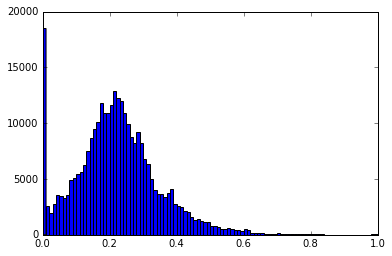

qg


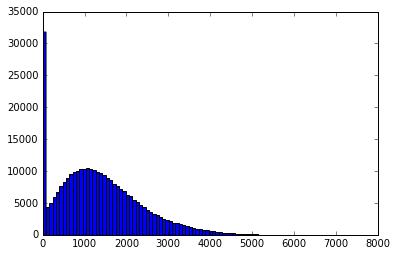

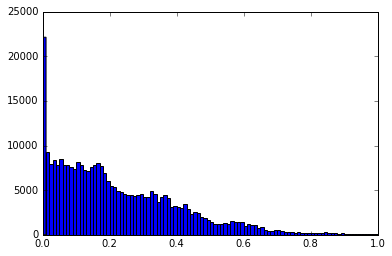

pc


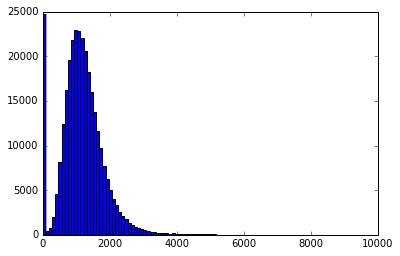

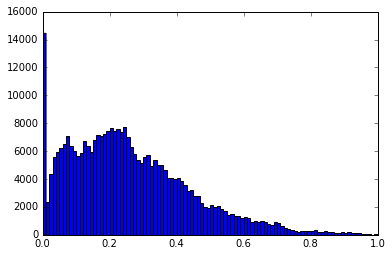

In [6]:
smoothened = defaultdict(list)
points = []
for chrom in chroms:
    for key in binned_chroms[chrom]:
        smoothened[key].extend(binned_chroms[chrom][key])
    points.append(len(binned_chroms[chrom][key]))
smoothened = dict(smoothened)
for key in smoothened:
    smoothened[key] = np.array(smoothened[key])

limits = {'pc': 4000, 'qg': 5000, 'snp': 20}
for key in smoothened:
    print (key)
    s = smoothened[key].copy()
    _ = plt.hist(s, bins=100)
    plt.show()
    s[s > limits[key]] = limits[key]
    s = stats.zscore(s)
    s[s < 0] = 0
    s = ndimage.gaussian_filter1d(s, 100)
    s = s / s.max()
    _ = plt.hist(s, bins=100)
    plt.show()
    smoothened[key] = s

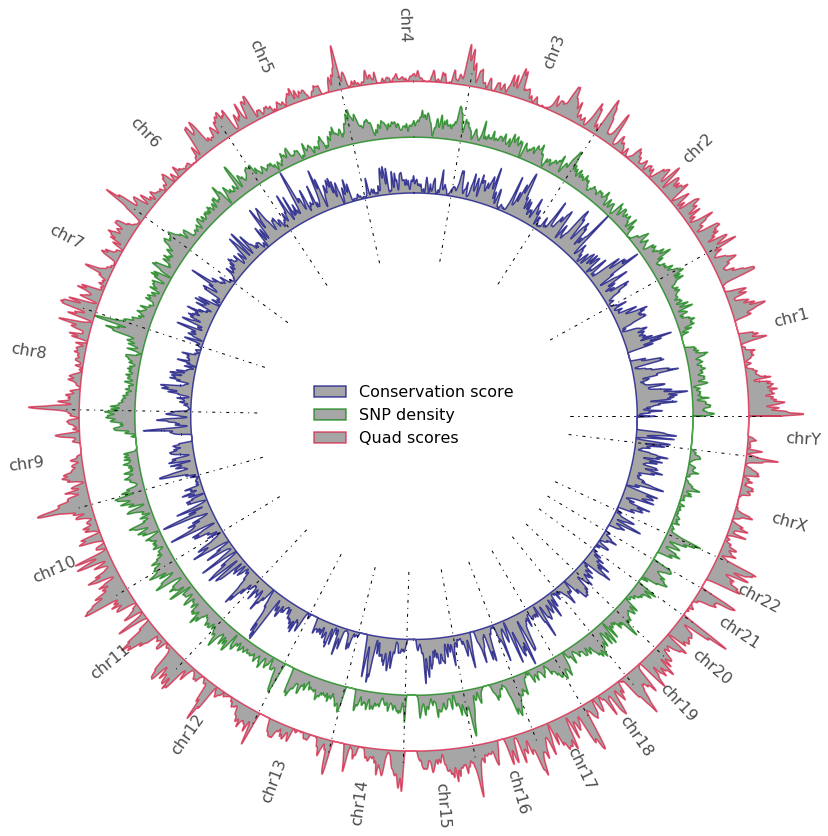

In [7]:
fig = plt.figure(figsize=(14, 14))
gs = mpl.gridspec.GridSpec(6, 6, hspace=0.5)
ax = fig.add_subplot(gs[:, :], projection='polar')

polar_pos = np.radians(np.linspace(0,360,len(smoothened['pc'])))
tracks = ['pc', 'snp', 'qg']
colors = {'pc' : 'navy', 'qg': 'crimson', 'snp': 'green'}
labels = {
    'pc': 'Conservation score',
    'qg': 'Quad scores',
    'snp': 'SNP density'
}
start_pos = 4
interval = 1
for n,i in enumerate(tracks):
    p = start_pos+(interval*n)
    fill_patch = ax.fill_between(polar_pos, p, smoothened[i] + p,
                color='grey', alpha=0.7, lw=1.5, label=labels[i])
    fill_patch.set_edgecolor(colors[i])

breaks_pos = np.cumsum([0.0] + points)
breaks_pos = np.radians((breaks_pos / breaks_pos[-1]) * 360)
for i in breaks_pos:
    ax.axvline(i, ymin=0.4, ymax=0.9, ls='-.', c='k', lw=1)
xticks = []
for i in range(len(breaks_pos)-1):
    xticks.append(((breaks_pos[i + 1] - breaks_pos[i]) / 2) + breaks_pos[i])
for i,j in zip([x for x in range(1, 23)]+['X', 'Y'], xticks):
    rotation = math.degrees(j)
    if 270 > rotation > 90:
        rotation-=180
    ax.text(j, p+interval, 'chr' + str(i), fontsize=16,
            color='black', alpha=0.7, horizontalalignment='center',
            verticalalignment='center',  rotation=rotation)
ax.set_xticks(xticks)
ax.xaxis.grid(False)
ax.set_xticklabels([])
ax.yaxis.grid(False)
ax.set_yticklabels([])
ax.spines['polar'].set_visible(False)
ax.legend(loc='center', fontsize=16, frameon=False)
plt.show()